In [1]:
import time
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/sem5/gnr/

/content/drive/MyDrive/sem5/gnr


In [4]:
from kervolution import *
from tools import *

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

batch_size = 8

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = [str(x) for x in range(10)]
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

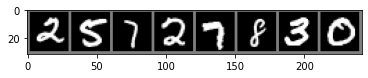

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
!ls

cifar_net.pth  data  kervolution.py  multikerv.py  __pycache__	tools.py


In [9]:
import torch.nn as nn
import torch.nn.functional as F
from kervolution import *
from tools import *

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = Kerv2d(in_channels=1,out_channels=6,kernel_size=(5,5),padding=0,stride=1)
        self.conv2 = Kerv2d(in_channels = 6, out_channels = 16,kernel_size = (5,5),padding=0,stride=1)
        self.conv3 = Kerv2d(in_channels = 16, out_channels = 120,kernel_size = (4,4),padding=0,stride=1)
        self.L1 = nn.Linear(120,84)
        self.L2 = nn.Linear(84,10)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.act = nn.Tanh()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.act(x)    
        x = x.view(x.size()[0], -1)
        x = self.L1(x)
        x = self.act(x)
        x = self.L2(x)
        return x


net = LeNet().to(device)
# net.load_state_dict(torch.load(PATH))

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
print(images.shape)

torch.Size([8, 1, 28, 28])


In [12]:
for epoch in range(2):  # loop over the dataset multiple times
    start_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f, time: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000, time.time() - start_time))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.188, time: 14.644
[1,  4000] loss: 0.334, time: 29.012
[1,  6000] loss: 0.241, time: 43.383
[2,  2000] loss: 0.146, time: 14.468
[2,  4000] loss: 0.135, time: 29.034
[2,  6000] loss: 0.121, time: 43.444
Finished Training


In [13]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [14]:
net = LeNet()
net.load_state_dict(torch.load(PATH))
net = net.to(device)
images = images.to(device)

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)    
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class 0     is: 98.7 %
Accuracy for class 1     is: 99.0 %
Accuracy for class 2     is: 98.0 %
Accuracy for class 3     is: 97.5 %
Accuracy for class 4     is: 94.9 %
Accuracy for class 5     is: 95.2 %
Accuracy for class 6     is: 96.9 %
Accuracy for class 7     is: 97.4 %
Accuracy for class 8     is: 97.7 %
Accuracy for class 9     is: 94.3 %
